In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size':15})
import sys
sys.path.insert(1, '/p/project/chhb19/gaertner2/lkf_detection/functions/')
from statistics_functions import *
from pyproj import Proj

In [2]:
path_loc = '/p/project/chhb19/gaertner2/data/awicm_cvmix/'
path_nc = '/p/scratch/chhb19/gaertner2/interpolated_fesom_output/1km/'

In [4]:
file = xr.open_dataset(path_nc + '1km_2013.nc')

lon = file.ULON
lat = file.ULAT

m = Proj(proj='stere',lat_0=90, lat_ts=70, lon_0=-45, ellps='WGS84')

x, y = m(lon, lat)
dxu = np.sqrt((x[:,1:]-x[:,:-1])**2 + (y[:,1:]-y[:,:-1])**2)
dxu = np.concatenate([dxu,dxu[:,-1].reshape((dxu.shape[0],1))],axis=1)
dyu = np.sqrt((x[1:,:]-x[:-1,:])**2 + (y[1:,:]-y[:-1,:])**2)
dyu = np.concatenate([dyu,dyu[-1,:].reshape((1,dyu.shape[1]))],axis=0)

res_km = 0.5 * (np.mean(dxu) + np.mean(dyu)) / 1000
res_km

4.337849218906646

In [5]:
years = [i for i in range(2013,2021)]
years += [i for i in range(2093,2101)]

In [12]:
[a_mean, a_tot, h_mean, h_tot] = [[] for _ in range(4)]
for year in years:
    file = xr.open_dataset(path_nc + f'ice_{year}.nc')
    
    a_mean += np.nanmean(file.A, axis=(1,2)),
    a_tot += np.nansum(file.A, axis=(1,2)) * res_km**2,
    
    ice = file.H
    ice = np.where(ice>0,ice,np.nan)
    
    h_mean += np.nanmean(ice, axis=(1,2)),
    h_tot += np.nanmean(ice * dxu * dyu, axis=(1,2)),

/tmp/ipykernel_21078/1392805688.py:11: RuntimeWarning: Mean of empty slice
  h_mean += np.nanmean(ice, axis=(1,2)),
/tmp/ipykernel_21078/1392805688.py:12: RuntimeWarning: Mean of empty slice
  h_tot += np.nanmean(ice * dxu * dyu, axis=(1,2)),


In [14]:
np.save(path_loc + 'years', years)
np.save(path_loc + 'a_mean_tot_h_mean_tot', [a_mean, a_tot, h_mean, h_tot])

In [21]:
[a_mean, a_tot, h_mean, h_tot] = np.load(path_loc + 'a_mean_tot_h_mean_tot.npy', allow_pickle=True)

In [22]:
a_mean_av, a_mean_sd, a_mean_90_av, a_mean_90_sd = av_sd(a_mean, i=8)
a_tot_av, a_tot_sd, a_tot_90_av, a_tot_90_sd = av_sd(a_tot, i=8)
h_mean_av, h_mean_sd, h_mean_90_av, h_mean_90_sd = av_sd(h_mean, i=8)
h_tot_av, h_tot_sd, h_tot_90_av, h_tot_90_sd = av_sd(h_tot, i=8)

In [23]:
def plot(var, label):
    
    color_range = np.linspace(0, 100, 8)
    norm = plt.Normalize(vmin=-50, vmax=100)
    cmap = plt.cm.Blues
    cmap2 = plt.cm.Oranges
    
    for a_tot_year, color in zip(var[:8], color_range):
        plt.plot(a_tot_year, color = cmap(norm(color)))

    for a_tot_year, color in zip(var[8:], color_range):
        plt.plot(a_tot_year, color = cmap2(norm(color)))


    plt.grid()
    p1 = mpatches.Patch(color='tab:blue', label='2010s')
    p2 = mpatches.Patch(color='tab:orange', label='2090s')
    plt.legend(handles=[p1, p2])
    plt.xlim([0,365])
    plt.xticks(xticks,[])
    plt.xticks(xticks_minor,xticks_labels, rotation=70, minor=True)
    plt.ylabel(rf'{label}')

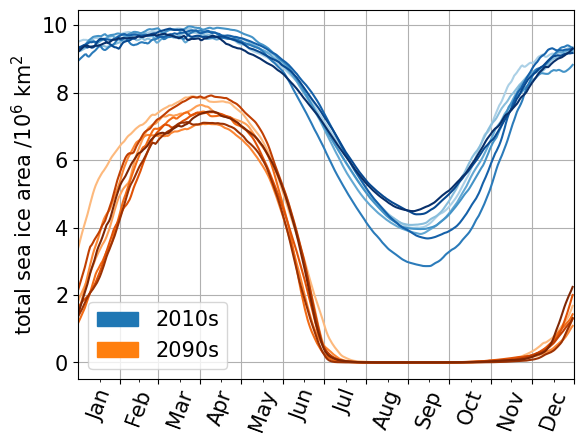

In [32]:
plot(np.array(a_tot)/1e6, 'total sea ice area /10$^6$ km$^2$')
#plt.savefig(path_loc + 'imgs/a_tot.png',dpi=100,bbox_inches='tight')

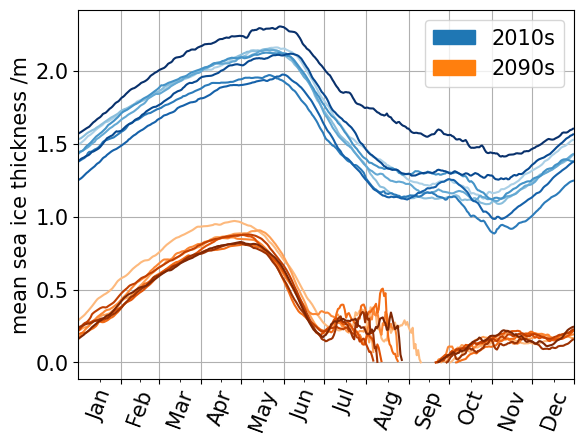

In [33]:
plot(h_mean, 'mean sea ice thickness /m')
#plt.savefig(path_loc + 'imgs/h_mean.png',dpi=100,bbox_inches='tight')

In [34]:
def plot2(arr, ylabel):
    for data, var, label in zip([arr[0], arr[1]],
                                [arr[2], arr[3]],
                                ['2010s', '2090s']):

        plt.plot(data,label=label)
        plt.fill_between(np.arange(365), data-var, data+var, alpha=0.5)
    plt.grid()
    plt.legend()
    plt.xlim([0,365])
    plt.xticks(xticks,[])
    plt.xticks(xticks_minor,xticks_labels, rotation=70, minor=True)
    plt.ylabel(rf'{ylabel}')

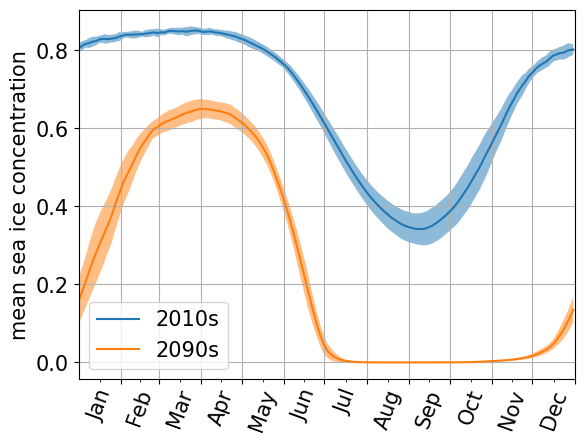

In [35]:
plot2(np.array([a_mean_av, a_mean_90_av, a_mean_sd, a_mean_90_sd]), r'mean sea ice concentration')
#plt.savefig(path_loc + 'imgs/a_mean_av.png',dpi=100,bbox_inches='tight')

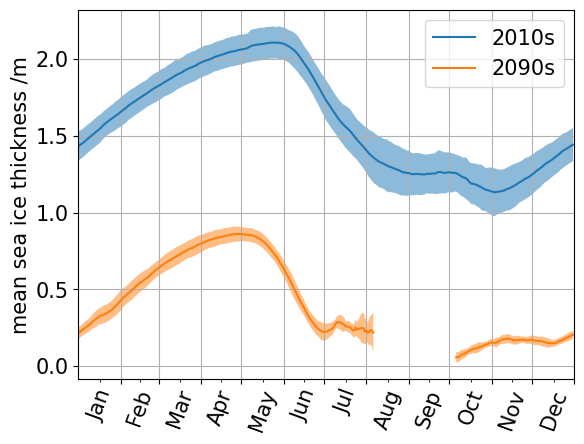

In [36]:
plot2([h_mean_av, h_mean_90_av, h_mean_sd, h_mean_90_sd], 'mean sea ice thickness /m')
#plt.savefig(path_loc + 'imgs/h_mean_av.png',dpi=100,bbox_inches='tight')